# Define the coordinates for the scan of the night sky

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ephem
import math

In [56]:
## Start time of the scan (UT)
time_start = '00:01:00'

## Cadence of the scan (in seconds), i.e., time interval between two telescope moves
cadence = 60

In [57]:
### Location parameter for Locarno Monti
MyHome = ephem.Observer()
MyHome.lon      = '8.7875'    # east +°
MyHome.lat      = '46.1723'  # north +°
MyHome.elev     = 374       # altitude in m asl
MyHome.temp     = 15        # °C
MyHome.pressure = 900       # mbar
name            = 'Locarno Monti' # name of the location from where the coordinates are taken

In [58]:
# Telescope parameter
AziMin    =  180-77 # east rotor limit
AziMax    =  180+77 # west rotor limit
EleMin    =  0 # 5m safety
EleMax    =  85.0
xT = [AziMin,AziMax,AziMax,AziMin,AziMin] # telescope frame azimuth
yT = [EleMin,EleMin,EleMax,EleMax,EleMin] # telescope frame elevation

In [59]:
def GeoSat(sat_lon):
    lat, lon = math.degrees(float(MyHome.lat)), math.degrees(float(MyHome.lon))
    rlat = math.radians(lat)
    rlon = math.radians(lon)
    rsat = math.radians(sat_lon)
    L = rsat - rlon
    D = math.acos(math.cos(rlat) * math.cos(L))
    az = math.degrees(math.acos(-math.tan(rlat) / math.tan(D)))
    az = az if L > 0 else 360 - az
    cd = math.cos(D)
    num = cd - 1 / 6.62
    den = (1 - cd * cd) ** 0.5
    el = math.degrees(math.atan(num / den))
    return(az,el)

In [60]:
### Calculate the azimuth and elevation of sun at the summer and winter solstice
year_ss = 2025
month_ss = 6
day_ss = 21

AZI_ss = []
ELE_ss = []
HM_ss  = []
hh_ss  = []
hhmm_ss = []
date_ss = []

sun_ss = ephem.Sun()
for h in range(0,24):
    for m in range(0,60,10):
        MyHome.date = '{:4d}/{:02d}/{:02d} {:02d}:{:02d}:{:02d}'.format(
                year_ss,month_ss,day_ss,h,m,0)
        sun_ss.compute(MyHome)
        Sazi = math.degrees(sun_ss.az)
        Sele = math.degrees(sun_ss.alt)
        
        #plt.plot(Sazi,Sele,'.r')
        hm = h+m/60
        HM_ss = np.append(HM_ss,hm)
        AZI_ss = np.append(AZI_ss,Sazi)
        ELE_ss = np.append(ELE_ss,Sele)
        st = '{:4.0f}'.format(hm)
        hh_ss = np.append(hh_ss,st)
        hhmm_ss = np.append(hhmm_ss,'{:02d}:{:02d}'.format(h,m))
        date_ss = np.append(date_ss,'{:4d}-{:02d}-{:02d}'.format(year_ss,month_ss,day_ss))

year_ws = 2025
month_ws = 12
day_ws = 21

AZI_ws = []
ELE_ws = []
HM_ws  = []
hh_ws  = []
hhmm_ws = []
date_ws = []

sun_ws = ephem.Sun()
for h in range(0,24):
    for m in range(0,60,10):
        MyHome.date = '{:4d}/{:02d}/{:02d} {:02d}:{:02d}:{:02d}'.format(
                year_ws,month_ws,day_ws,h,m,0)
        sun_ws.compute(MyHome)
        Sazi = math.degrees(sun_ws.az)
        Sele = math.degrees(sun_ws.alt)
        
        #plt.plot(Sazi,Sele,'.r')
        hm = h+m/60
        HM_ws = np.append(HM_ws,hm)
        AZI_ws = np.append(AZI_ws,Sazi)
        ELE_ws = np.append(ELE_ws,Sele)
        st = '{:4.0f}'.format(hm)
        hh_ws = np.append(hh_ws,st)
        hhmm_ws = np.append(hhmm_ws,'{:02d}:{:02d}'.format(h,m))
        date_ws = np.append(date_ws,'{:4d}-{:02d}-{:02d}'.format(year_ws,month_ws,day_ws))

In [61]:
today = pd.Timestamp.today().strftime('%Y-%m-%d')
scan_start = pd.Timestamp(today + ' ' + time_start)
scan_start

Timestamp('2025-03-04 00:01:00')

In [62]:
azi1 = np.linspace(105, 255, 16)
azi2 = np.linspace(110, 250, 15)
ele = np.linspace(-5, 75, 17)

In [63]:
pos_azi = []
pos_ele = []
for i in range(len(ele)):
    if i % 2 == 0:
        pos_azi = np.concatenate((pos_azi, azi1))
        pos_ele = np.concatenate((pos_ele, np.ones(len(azi1)) * ele[len(ele)-i-1]))
    else:
        pos_azi = np.concatenate((pos_azi, azi2[::-1]))
        pos_ele = np.concatenate((pos_ele, np.ones(len(azi2)) * ele[len(ele)-i-1]))

In [64]:
scan_time = scan_start + pd.to_timedelta(np.arange(len(pos_azi)) * cadence, unit='s')
scan_time[0], scan_time[-1]

(Timestamp('2025-03-04 00:01:00'), Timestamp('2025-03-04 04:24:00'))

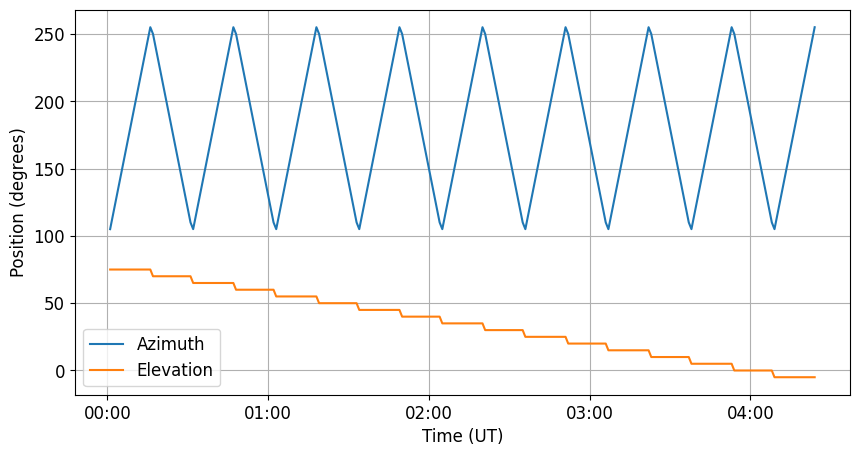

In [65]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10, 5))
plt.plot(scan_time, pos_azi, label='Azimuth')
plt.plot(scan_time, pos_ele, label='Elevation')
plt.xlabel('Time (UT)')
plt.ylabel('Position (degrees)')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.HourLocator(interval=1))
plt.grid()
plt.legend()

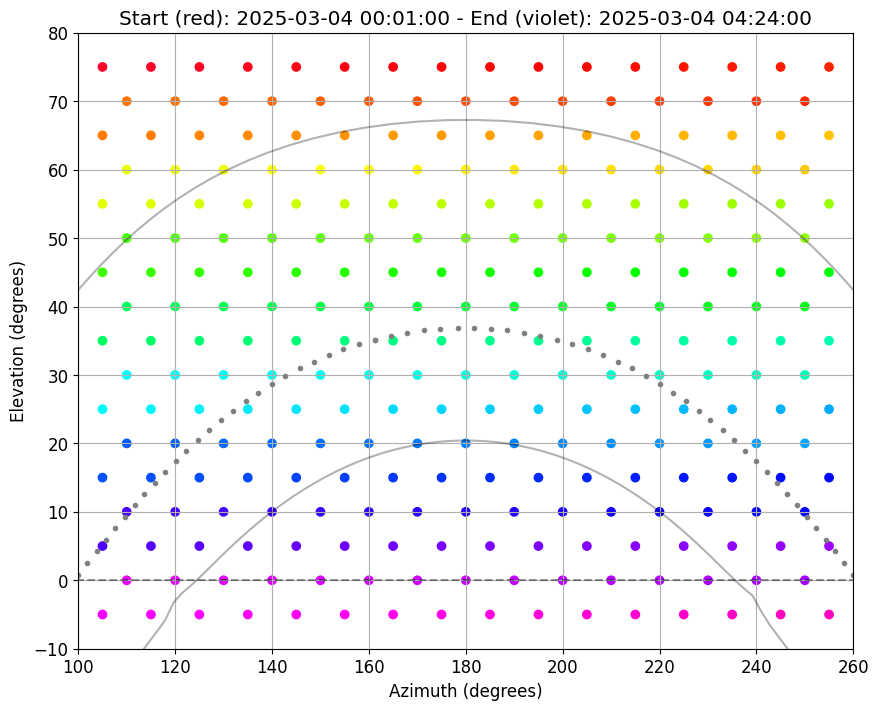

In [66]:
plt.figure(figsize=(10, 8))
plt.plot(AZI_ss,ELE_ss,'-',c='black',alpha=0.3)
plt.plot(AZI_ws,ELE_ws,'-',c='black',alpha=0.3)
plt.hlines(0, 50, 300, colors='k', linestyles='dashed', alpha=0.4)

az_sat = []
el_sat = []
for sat in range (0,360,5):
    a,e = GeoSat(sat)
    if (e > 0):
            plt.plot(a,e,'.',c='gray')
            az_sat = np.append(az_sat,a)
            el_sat = np.append(el_sat,e)
    plt.plot(360-a,e,'.',c='gray') 
    az_sat = np.append(az_sat,360-a)
    el_sat = np.append(el_sat,e)
plt.plot(a,e,'.',c='gray',label='Geostationary orbit')

plt.scatter(pos_azi, pos_ele, c=scan_time, cmap='gist_rainbow')
plt.xlabel('Azimuth (degrees)')
plt.ylabel('Elevation (degrees)')
#plt.colorbar(label='Time (UT)')
plt.xlim(100, 260)
plt.ylim(-10, 80)
plt.title('Start (red): ' + str(scan_time[0]) + ' - End (violet): ' + str(scan_time[-1]))
plt.grid()
plt.show()

In [67]:
string_time = [t.strftime('%H:%M:%S') for t in scan_time.time]

In [68]:
df = pd.DataFrame({'time_UT': string_time, 'azimuth_deg': pos_azi, 'elevation_deg': pos_ele})
df.to_csv('coordinates_night-scan-plan.csv', index=False)